**Import Libraries**

In [74]:
import pandas as pd
from sklearn.impute import KNNImputer
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import matplotlib.pyplot as plt

**Data Loading and EDA**

**For Generation Data**

  * DATE_TIME - Date and time for each observation. Observations recorded at 15
minute intervals

  * PLANT_ID - ID of Solar Power Plant (common for the entire file)
SOURCE_KEY - Inverter ID

  * DC_POWER - Amount of DC power input to the inverter (SOURCE_KEY) at interval (in kW)

  * AC_POWER - Amount of AC power generated by the inverter (SOURCE_KEY) at interval (in kW)

  * DAILY_YIELD - Cumulative sum of power generated on that day, till that point in time

  * TOTAL_YIELD - Total yield for the inverter till that point in time
For Weather Sensor Data

  * DATE_TIME - Date and time for each observation. Observations recorded at 15 minute intervals

  * PLANT_ID - ID of Solar Power Plant (common for the entire file)

  * SOURCE_KEY - Sensor panel ID (Common for entire file, only one type of sensor panel for the plant)
  * AMBIENT_TEMPERATURE - Ambient temperature at the plant

  * MODULE_TEMPERATURE - Temperature reading for module attached to the sensor panel

  * IRRADIATION - Amount of irradiation for the 15 minute interval

In [75]:
# Read the generation data
generation_data_p1 = pd.read_csv('../data/Plant_1_Generation_Data.csv')
generation_data_p1['DC_POWER'] = generation_data_p1['DC_POWER'].div(1000)
generation_data_p1['AC_POWER'] = generation_data_p1['AC_POWER'].div(100)
generation_data_p1['DATE_TIME'] = pd.to_datetime(generation_data_p1['DATE_TIME'])
generation_data_p1.set_index('DATE_TIME', inplace=True)

# Read the weather data
weather_data_p1 = pd.read_csv('../data/Plant_1_Weather_Sensor_Data.csv')
weather_data_p1['DATE_TIME'] = pd.to_datetime(weather_data_p1['DATE_TIME'])
weather_data_p1.set_index('DATE_TIME', inplace=True)

<ipython-input-75-ff53b35dfffe>:5: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  generation_data_p1['DATE_TIME'] = pd.to_datetime(generation_data_p1['DATE_TIME'])


In [76]:

# Resample both datasets to daily data
df_weather = weather_data_p1.drop('SOURCE_KEY', axis=1).resample('D').mean()
df_generation = generation_data_p1.drop('SOURCE_KEY', axis=1).resample('D').mean()

# Merge the resampled datasets
df = pd.merge(df_generation, df_weather, left_index=True, right_index=True, how='inner', suffixes=('_gen', '_weather'))

# Add a column for previous day's DC_POWER
df['DC_POWER-1'] = df['DC_POWER'].shift(1)

# Drop unwanted columns
df = df.drop(['PLANT_ID_gen', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'PLANT_ID_weather'], axis=1)

# Resample both datasets to hourly data
df_weather_hrs = weather_data_p1.drop('SOURCE_KEY', axis=1).resample('h').mean()
df_generation_hrs = generation_data_p1.drop('SOURCE_KEY', axis=1).resample('h').mean()

# Merge the resampled hourly datasets
df_hrs = pd.merge(df_generation_hrs, df_weather_hrs, left_index=True, right_index=True, how='inner', suffixes=('_gen', '_weather'))

# Add an hour column
df_hrs['hour'] = df_hrs.index.hour

# Shift hour data to columns
df_hrs_2 = df_hrs.set_index('hour', append=True).unstack(level=-1)[['DC_POWER', 'IRRADIATION', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE']]

# Rename the columns
df_hrs_2.columns = [f'{column}-{hour:02d}' for column, hour in df_hrs_2.columns]

# Keep only the first row (00:00:00) for each day
df_hrs_f = df_hrs_2.groupby(df_hrs_2.index.date).first()

In [77]:

# Create KNN imputer object
imputer = KNNImputer(n_neighbors=5) # Use 5 nearest neighbors

# Fit and transform data to impute missing values
imputed_data = imputer.fit_transform(df_hrs_f)

# Recreate DataFrame with imputed values and original column names
df_hrs_imputed = pd.DataFrame(imputed_data, index=df_hrs_f.index, columns=df_hrs_f.columns)
merged_df = df_hrs_imputed.iloc[:-1]

# Read the CSV file containing the generation data
data = pd.read_csv('../data/Plant_1_Generation_Data.csv')
# Convert the DATE_TIME column to datetime type
data['DATE_TIME'] = pd.to_datetime(data['DATE_TIME'])

# Group the data by date and calculate the average DC_POWER
average_dc_power = data.groupby(data['DATE_TIME'].dt.date)['DC_POWER'].mean()/1000

average_dc_power = average_dc_power.shift(-1)
average_dc_power = average_dc_power[:-1]  # Remove the last element

# Merge average_dc_power with merged_df
merged_df.insert(0, 'DC_Power_Next_Day_AVG', average_dc_power.values)

<ipython-input-77-58aa5414bee6>:14: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['DATE_TIME'] = pd.to_datetime(data['DATE_TIME'])


**DC prediction with kNN for each feature**

In [78]:
# Features division based on the columns specified
# DC_POWER: columns 1 to 24
# IRRADIATION: columns 25 to 48
# AMBIENT_TEMPERATURE: columns 49 to 72
# MODULE_TEMPERATURE: columns 73 to 96

X_dc_power = merged_df.iloc[:, 1:25].values
X_irradiation = merged_df.iloc[:, 25:49].values
X_ambient_temp = merged_df.iloc[:, 49:73].values
X_module_temp = merged_df.iloc[:, 73:97].values

# Target variable
y = merged_df.iloc[:, 0].values

In [79]:
# 1. Split the data into training and test sets
test_size = 7
train_size = int(len(y) - test_size)

# Splitting for each feature set
X_train_dc, X_test_dc = X_dc_power[:train_size], X_dc_power[train_size:]
X_train_irr, X_test_irr = X_irradiation[:train_size], X_irradiation[train_size:]
X_train_amb, X_test_amb = X_ambient_temp[:train_size], X_ambient_temp[train_size:]
X_train_mod, X_test_mod = X_module_temp[:train_size], X_module_temp[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Hyperparameter tuning and model training for each feature set
def train_knn(X_train, y_train):
    k_values = list(range(3, 7))
    rmse_values = []

    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k)
        tscv = TimeSeriesSplit(n_splits=5)
        scores = -cross_val_score(knn, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')
        avg_rmse = np.mean(scores)
        rmse_values.append(avg_rmse)

    # Find best k
    best_rmse = min(rmse_values)
    best_k = k_values[rmse_values.index(best_rmse)]

    # Train KNN model with best k
    knn = KNeighborsRegressor(n_neighbors=best_k)
    knn.fit(X_train, y_train)

    return knn, best_k, k_values, rmse_values

In [80]:
# Train and predict for each feature set
knn_dc, best_k_dc, k_values_dc, rmse_values_dc = train_knn(X_train_dc, y_train)
y_pred_dc = knn_dc.predict(X_test_dc)
rmse_dc = np.sqrt(mse(y_test, y_pred_dc))

knn_irr, best_k_irr, k_values_irr, rmse_values_irr = train_knn(X_train_irr, y_train)
y_pred_irr = knn_irr.predict(X_test_irr)
rmse_irr = np.sqrt(mse(y_test, y_pred_irr))

knn_amb, best_k_amb, k_values_amb, rmse_values_amb = train_knn(X_train_amb, y_train)
y_pred_amb = knn_amb.predict(X_test_amb)
rmse_amb = np.sqrt(mse(y_test, y_pred_amb))

knn_mod, best_k_mod, k_values_mod, rmse_values_mod = train_knn(X_train_mod, y_train)
y_pred_mod = knn_mod.predict(X_test_mod)
rmse_mod = np.sqrt(mse(y_test, y_pred_mod))

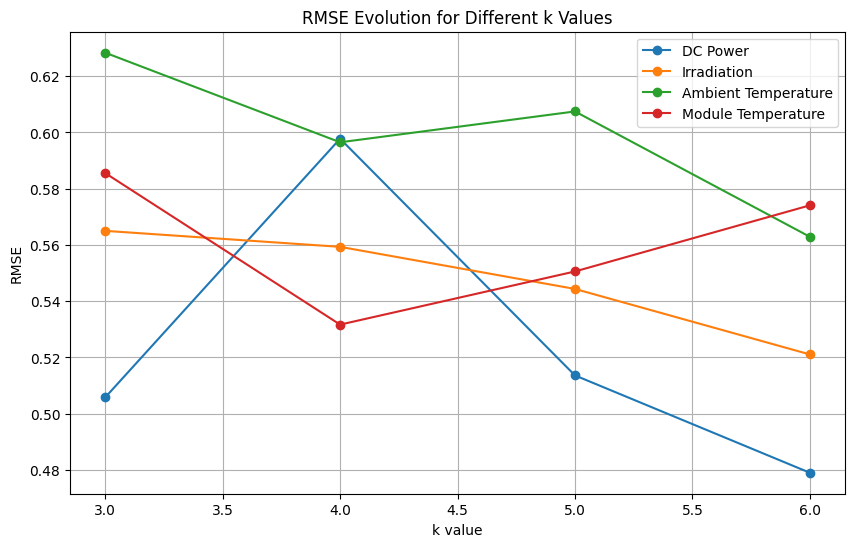

In [81]:
# Plotting RMSE evolution for each feature set
plt.figure(figsize=(10, 6))
plt.plot(k_values_dc, rmse_values_dc, label='DC Power', marker='o')
plt.plot(k_values_irr, rmse_values_irr, label='Irradiation', marker='o')
plt.plot(k_values_amb, rmse_values_amb, label='Ambient Temperature', marker='o')
plt.plot(k_values_mod, rmse_values_mod, label='Module Temperature', marker='o')
plt.xlabel('k value')
plt.ylabel('RMSE')
plt.title('RMSE Evolution for Different k Values')
plt.legend()
plt.grid(True)
plt.show()

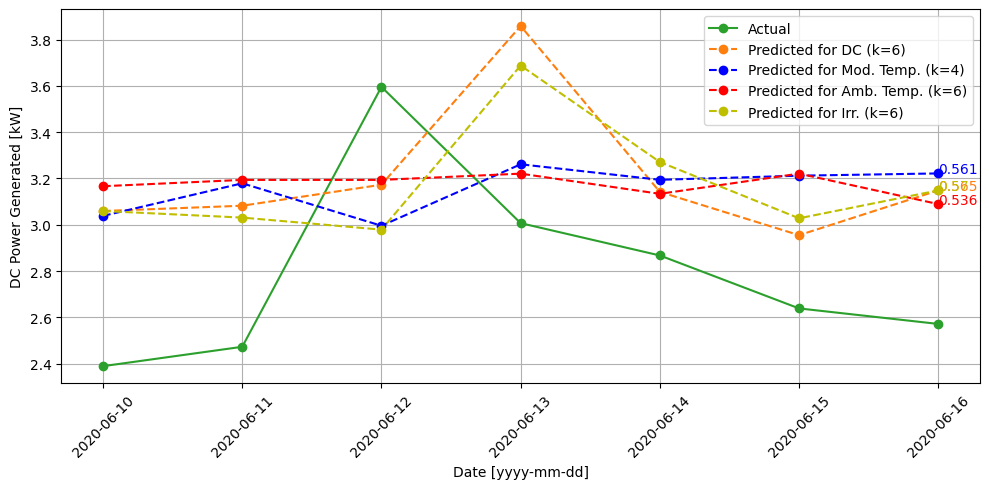

In [82]:
# Create a dictionary to mimic the `predictions_dict` used in the plotting code
predictions_dict = {
    str(['DC_POWER']): pd.Series(y_pred_dc, index=merged_df.index[-test_size:]),
    str(['MODULE_TEMPERATURE']): pd.Series(y_pred_mod, index=merged_df.index[-test_size:]),
    str(['AMBIENT_TEMPERATURE']): pd.Series(y_pred_amb, index=merged_df.index[-test_size:]),
    str(['IRRADIATION']): pd.Series(y_pred_irr, index=merged_df.index[-test_size:]),
}

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
y_test_series = pd.Series(y[-test_size:].flatten(), index=merged_df.index[-test_size:])
ax.plot(y_test_series.index, y_test_series, color='#2ca02c', marker='o', label='Actual')

# Plot model predictions for each chosen feature set
ax.plot(predictions_dict[str(['DC_POWER'])].index, predictions_dict[str(['DC_POWER'])], color='#ff7f0e', label=f'Predicted for DC (k={best_k_dc})', marker='o', linestyle='--')
ax.plot(predictions_dict[str(['MODULE_TEMPERATURE'])].index, predictions_dict[str(['MODULE_TEMPERATURE'])], color='b', label=f'Predicted for Mod. Temp. (k={best_k_mod})', marker='o', linestyle='--')
ax.plot(predictions_dict[str(['AMBIENT_TEMPERATURE'])].index, predictions_dict[str(['AMBIENT_TEMPERATURE'])], color='r', label=f'Predicted for Amb. Temp. (k={best_k_amb})', marker='o', linestyle='--')
ax.plot(predictions_dict[str(['IRRADIATION'])].index, predictions_dict[str(['IRRADIATION'])], color='y', label=f'Predicted for Irr. (k={best_k_irr})', marker='o', linestyle='--')
ax.set_xlabel('Date [yyyy-mm-dd]')
ax.set_ylabel('DC Power Generated [kW]')
plt.xticks(rotation=45)
plt.tight_layout()
ax.legend()
ax.grid(True)

# Add RMSE value next to the last point of each plot
last_point_x = y_test_series.index[-1]
ax.text(last_point_x, predictions_dict[str(['DC_POWER'])].iloc[-1], f'{rmse_dc:.3f}', color='#ff7f0e')
ax.text(last_point_x, predictions_dict[str(['MODULE_TEMPERATURE'])].iloc[-1], f'{rmse_mod:.3f}', color='b')
ax.text(last_point_x, predictions_dict[str(['AMBIENT_TEMPERATURE'])].iloc[-1], f'{rmse_amb:.3f}', color='r')
ax.text(last_point_x, predictions_dict[str(['IRRADIATION'])].iloc[-1], f'{rmse_irr:.2f}', color='y')
plt.show()


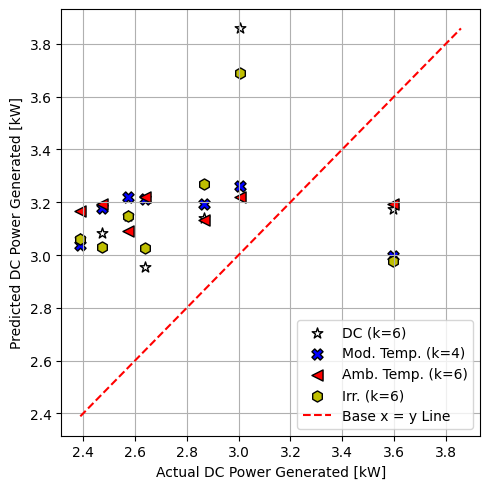

In [83]:
# Scatter plot for actual vs. predicted values
fig, ax = plt.subplots(figsize=(5, 5))
y_test_series = pd.Series(y[-test_size:].flatten(), index=merged_df.index[-test_size:])
sc1 = ax.scatter(y_test_series, predictions_dict[str(['DC_POWER'])], color='w', label=f'DC (k={best_k_dc})', marker='*', edgecolors='k', s=64)
sc2 = ax.scatter(y_test_series, predictions_dict[str(['MODULE_TEMPERATURE'])], color='b', label=f'Mod. Temp. (k={best_k_mod})', marker='X', edgecolors='k', s=64)
sc3 = ax.scatter(y_test_series, predictions_dict[str(['AMBIENT_TEMPERATURE'])], color='r', label=f'Amb. Temp. (k={best_k_amb})', marker='<', edgecolors='k', s=64)
sc4 = ax.scatter(y_test_series, predictions_dict[str(['IRRADIATION'])], color='y', label=f'Irr. (k={best_k_irr})', marker='h', edgecolors='k', s=64)
min_val = min(y_test_series.min(), min(y_pred_series.min() for y_pred_series in predictions_dict.values()))
max_val = max(y_test_series.max(), max(y_pred_series.max() for y_pred_series in predictions_dict.values()))
ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='r', label='Base x = y Line')
ax.set_xlabel('Actual DC Power Generated [kW]')
ax.set_ylabel('Predicted DC Power Generated [kW]')
plt.tight_layout()
ax.legend()
ax.grid(True)
plt.show()

**DC prediction with kNN with mixing of features**


In [84]:
# Features division based on the columns specified
# DC_POWER: columns 1 to 24
# IRRADIATION: columns 25 to 48
# AMBIENT_TEMPERATURE: columns 49 to 72
# MODULE_TEMPERATURE: columns 73 to 96

X_dc_power = merged_df.iloc[:, 1:25].values
X_irradiation = merged_df.iloc[:, 25:49].values
X_ambient_temp = merged_df.iloc[:, 49:73].values
X_module_temp = merged_df.iloc[:, 73:97].values

# Combine features for different combinations
X_dc_irr = np.hstack((X_dc_power, X_irradiation))
X_dc_amb = np.hstack((X_dc_power, X_ambient_temp))
X_dc_mod = np.hstack((X_dc_power, X_module_temp))

# Target variable
y = merged_df.iloc[:, 0].values


In [85]:
# 1. Split the data into training and test sets
test_size = 7
train_size = int(len(y) - test_size)

# Splitting for each feature set
X_train_dc, X_test_dc = X_dc_power[:train_size], X_dc_power[train_size:]
X_train_irr, X_test_irr = X_irradiation[:train_size], X_irradiation[train_size:]
X_train_amb, X_test_amb = X_ambient_temp[:train_size], X_ambient_temp[train_size:]
X_train_mod, X_test_mod = X_module_temp[:train_size], X_module_temp[train_size:]

X_train_dc_irr, X_test_dc_irr = X_dc_irr[:train_size], X_dc_irr[train_size:]
X_train_dc_amb, X_test_dc_amb = X_dc_amb[:train_size], X_dc_amb[train_size:]
X_train_dc_mod, X_test_dc_mod = X_dc_mod[:train_size], X_dc_mod[train_size:]

y_train, y_test = y[:train_size], y[train_size:]

In [86]:
# Hyperparameter tuning and model training for each feature set
def train_knn(X_train, y_train):
    k_values = list(range(3, 7))
    rmse_values = []

    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k)
        tscv = TimeSeriesSplit(n_splits=5)
        scores = -cross_val_score(knn, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')
        avg_rmse = np.mean(scores)
        rmse_values.append(avg_rmse)

    # Find best k
    best_rmse = min(rmse_values)
    best_k = k_values[rmse_values.index(best_rmse)]

    # Train KNN model with best k
    knn = KNeighborsRegressor(n_neighbors=best_k)
    knn.fit(X_train, y_train)

    return knn, best_k, k_values, rmse_values

In [87]:
# Train and predict for each feature set
knn_dc, best_k_dc, k_values_dc, rmse_values_dc = train_knn(X_train_dc, y_train)
y_pred_dc = knn_dc.predict(X_test_dc)
rmse_dc = np.sqrt(mse(y_test, y_pred_dc))

knn_dc_irr, best_k_dc_irr, k_values_dc_irr, rmse_values_dc_irr = train_knn(X_train_dc_irr, y_train)
y_pred_dc_irr = knn_dc_irr.predict(X_test_dc_irr)
rmse_dc_irr = np.sqrt(mse(y_test, y_pred_dc_irr))

knn_dc_amb, best_k_dc_amb, k_values_dc_amb, rmse_values_dc_amb = train_knn(X_train_dc_amb, y_train)
y_pred_dc_amb = knn_dc_amb.predict(X_test_dc_amb)
rmse_dc_amb = np.sqrt(mse(y_test, y_pred_dc_amb))

knn_dc_mod, best_k_dc_mod, k_values_dc_mod, rmse_values_dc_mod = train_knn(X_train_dc_mod, y_train)
y_pred_dc_mod = knn_dc_mod.predict(X_test_dc_mod)
rmse_dc_mod = np.sqrt(mse(y_test, y_pred_dc_mod))

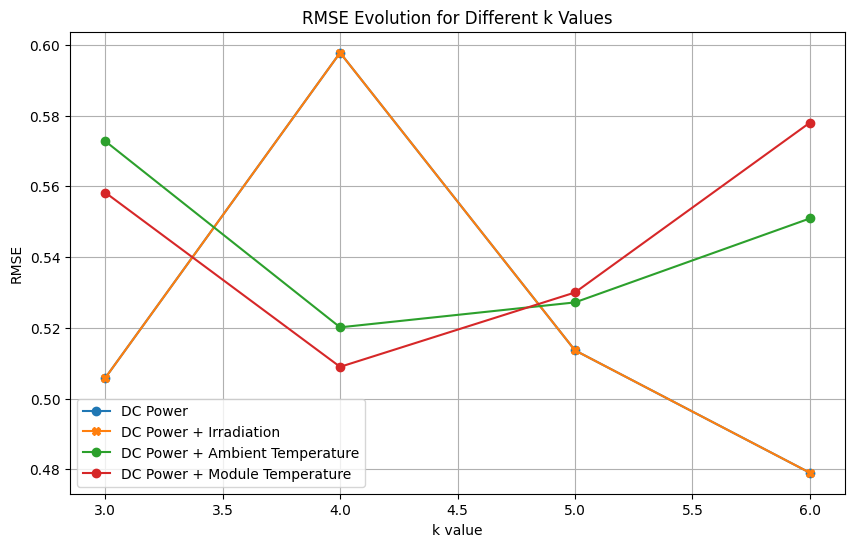

In [88]:
# Plotting RMSE evolution for each feature set
plt.figure(figsize=(10, 6))
plt.plot(k_values_dc, rmse_values_dc, label='DC Power', marker='o')
plt.plot(k_values_dc_irr, rmse_values_dc_irr, label='DC Power + Irradiation', marker='X')
plt.plot(k_values_dc_amb, rmse_values_dc_amb, label='DC Power + Ambient Temperature', marker='o')
plt.plot(k_values_dc_mod, rmse_values_dc_mod, label='DC Power + Module Temperature', marker='o')
plt.xlabel('k value')
plt.ylabel('RMSE')
plt.title('RMSE Evolution for Different k Values')
plt.legend()
plt.grid(True)
plt.show()


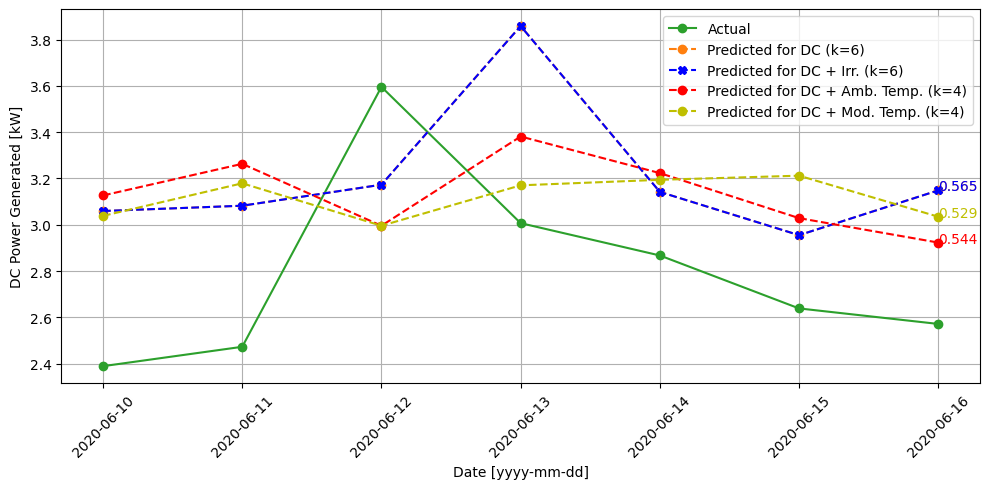

In [89]:
# Create a dictionary to mimic the `predictions_dict` used in the plotting code
predictions_dict = {
    str(['DC_POWER']): pd.Series(y_pred_dc, index=merged_df.index[-test_size:]),
    str(['DC_POWER', 'IRRADIATION']): pd.Series(y_pred_dc_irr, index=merged_df.index[-test_size:]),
    str(['DC_POWER', 'AMBIENT_TEMPERATURE']): pd.Series(y_pred_dc_amb, index=merged_df.index[-test_size:]),
    str(['DC_POWER', 'MODULE_TEMPERATURE']): pd.Series(y_pred_dc_mod, index=merged_df.index[-test_size:]),
}

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
y_test_series = pd.Series(y[-test_size:].flatten(), index=merged_df.index[-test_size:])
ax.plot(y_test_series.index, y_test_series, color='#2ca02c', marker='o', label='Actual')

# Plot model predictions for each chosen feature set
ax.plot(predictions_dict[str(['DC_POWER'])].index, predictions_dict[str(['DC_POWER'])], color='#ff7f0e', label=f'Predicted for DC (k={best_k_dc})', marker='o', linestyle='--')
ax.plot(predictions_dict[str(['DC_POWER', 'IRRADIATION'])].index, predictions_dict[str(['DC_POWER', 'IRRADIATION'])], color='b', label=f'Predicted for DC + Irr. (k={best_k_dc_irr})', marker='X', linestyle='--')
ax.plot(predictions_dict[str(['DC_POWER', 'AMBIENT_TEMPERATURE'])].index, predictions_dict[str(['DC_POWER', 'AMBIENT_TEMPERATURE'])], color='r', label=f'Predicted for DC + Amb. Temp. (k={best_k_dc_amb})', marker='o', linestyle='--')
ax.plot(predictions_dict[str(['DC_POWER', 'MODULE_TEMPERATURE'])].index, predictions_dict[str(['DC_POWER', 'MODULE_TEMPERATURE'])], color='y', label=f'Predicted for DC + Mod. Temp. (k={best_k_dc_mod})', marker='o', linestyle='--')
ax.set_xlabel('Date [yyyy-mm-dd]')
ax.set_ylabel('DC Power Generated [kW]')
plt.xticks(rotation=45)
plt.tight_layout()
ax.legend()
ax.grid(True)

# Add RMSE value next to the last point of each plot
last_point_x = y_test_series.index[-1]
ax.text(last_point_x, predictions_dict[str(['DC_POWER'])].iloc[-1], f'{rmse_dc:.3f}', color='#ff7f0e')
ax.text(last_point_x, predictions_dict[str(['DC_POWER', 'IRRADIATION'])].iloc[-1], f'{rmse_dc_irr:.3f}', color='b')
ax.text(last_point_x, predictions_dict[str(['DC_POWER', 'AMBIENT_TEMPERATURE'])].iloc[-1], f'{rmse_dc_amb:.3f}', color='r')
ax.text(last_point_x, predictions_dict[str(['DC_POWER', 'MODULE_TEMPERATURE'])].iloc[-1], f'{rmse_dc_mod:.3f}', color='y')
plt.show()

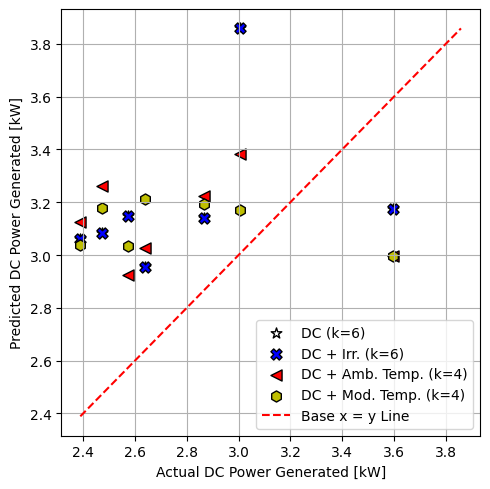

In [90]:
# Scatter plot for actual vs. predicted values
fig, ax = plt.subplots(figsize=(5, 5))
y_test_series = pd.Series(y[-test_size:].flatten(), index=merged_df.index[-test_size:])
sc1 = ax.scatter(y_test_series, predictions_dict[str(['DC_POWER'])], color='w', label=f'DC (k={best_k_dc})', marker='*', edgecolors='k', s=64)
sc2 = ax.scatter(y_test_series, predictions_dict[str(['DC_POWER', 'IRRADIATION'])], color='b', label=f'DC + Irr. (k={best_k_dc_irr})', marker='X', edgecolors='k', s=64)
sc3 = ax.scatter(y_test_series, predictions_dict[str(['DC_POWER', 'AMBIENT_TEMPERATURE'])], color='r', label=f'DC + Amb. Temp. (k={best_k_dc_amb})', marker='<', edgecolors='k', s=64)
sc4 = ax.scatter(y_test_series, predictions_dict[str(['DC_POWER', 'MODULE_TEMPERATURE'])], color='y', label=f'DC + Mod. Temp. (k={best_k_dc_mod})', marker='h', edgecolors='k', s=64)
min_val = min(y_test_series.min(), min(y_pred_series.min() for y_pred_series in predictions_dict.values()))
max_val = max(y_test_series.max(), max(y_pred_series.max() for y_pred_series in predictions_dict.values()))
ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='r', label='Base x = y Line')
ax.set_xlabel('Actual DC Power Generated [kW]')
ax.set_ylabel('Predicted DC Power Generated [kW]')
plt.tight_layout()
ax.legend()
ax.grid(True)
plt.show()

**DC prediction using just one day as input for multivariate and univariate**

<ipython-input-91-64abb41a2466>:13: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  generation_data_p1['DATE_TIME'] = pd.to_datetime(generation_data_p1['DATE_TIME'])
<ipython-input-91-64abb41a2466>:36: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  generation_data['DATE_TIME'] = pd.to_datetime(generation_data['DATE_TIME'])


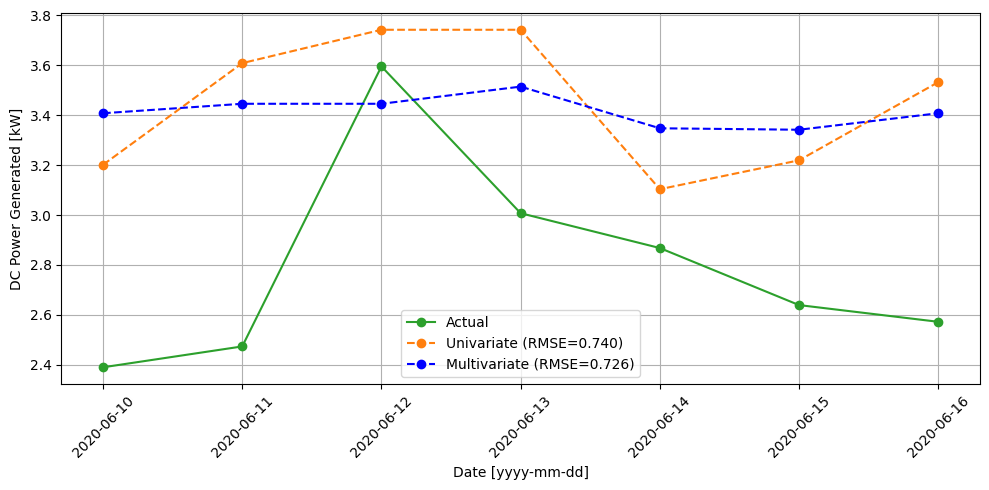

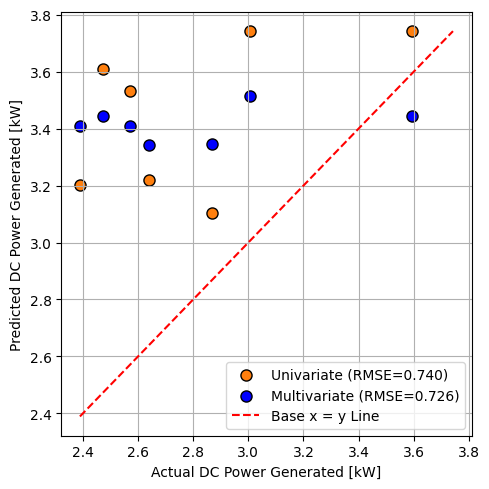

In [91]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split
import matplotlib.pyplot as plt

# Read the generation data
generation_data_p1 = pd.read_csv('../data/Plant_1_Generation_Data.csv')
generation_data_p1['DC_POWER'] = generation_data_p1['DC_POWER'].div(1000)
generation_data_p1['AC_POWER'] = generation_data_p1['AC_POWER'].div(100)
generation_data_p1['DATE_TIME'] = pd.to_datetime(generation_data_p1['DATE_TIME'])
generation_data_p1.set_index('DATE_TIME', inplace=True)

# Read the weather data
weather_data_p1 = pd.read_csv('../data/Plant_1_Weather_Sensor_Data.csv')
weather_data_p1['DATE_TIME'] = pd.to_datetime(weather_data_p1['DATE_TIME'])
weather_data_p1.set_index('DATE_TIME', inplace=True)

# Resample both datasets to daily data
df_weather = weather_data_p1.drop('SOURCE_KEY', axis=1).resample('D').mean()
df_generation = generation_data_p1.drop('SOURCE_KEY', axis=1).resample('D').mean()

# Merge the resampled daily datasets
df = pd.merge(df_generation, df_weather, left_index=True, right_index=True, how='inner', suffixes=('_gen', '_weather'))

# Add a column for the previous day's DC_POWER
df['DC_POWER-1'] = df['DC_POWER'].shift(1)

# Drop unwanted columns
df = df.drop(['PLANT_ID_gen', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'PLANT_ID_weather'], axis=1)

# Read the CSV file containing the generation data for computing the daily average DC_POWER
generation_data = pd.read_csv('../data/Plant_1_Generation_Data.csv')
generation_data['DATE_TIME'] = pd.to_datetime(generation_data['DATE_TIME'])

# Group the data by date and calculate the average DC_POWER
average_dc_power = generation_data.groupby(generation_data['DATE_TIME'].dt.date)['DC_POWER'].mean() / 1000

# Shift the average DC_POWER to represent the next day's value
average_dc_power = average_dc_power.shift(-1).iloc[:-1]

# Align the index of the main DataFrame to match the length of average_dc_power
df = df.iloc[:-1]

# Insert the average next day's DC_POWER into the main DataFrame
df.insert(0, 'DC_Power_Next_Day_AVG', average_dc_power.values)

# Create KNN imputer object
imputer = KNNImputer(n_neighbors=5)

# Fit and transform data to impute missing values
imputed_data = imputer.fit_transform(df)

# Recreate DataFrame with imputed values and original column names
df_imputed = pd.DataFrame(imputed_data, index=df.index, columns=df.columns)

# Prepare the features and target
X_multivariate = df_imputed.drop(columns=['DC_Power_Next_Day_AVG'])
y_multivariate = df_imputed['DC_Power_Next_Day_AVG']
X_univariate = df_imputed[['DC_POWER-1']]
y_univariate = df_imputed['DC_Power_Next_Day_AVG']

# Split the data into training and testing sets for both models using the same parameters as the provided code
test_size = 7
train_size = int(len(y_univariate) - test_size)

# Train and test splits for univariate model
X_train_uni, X_test_uni = X_univariate[:train_size], X_univariate[train_size:]
y_train_uni, y_test_uni = y_univariate[:train_size], y_univariate[train_size:]

# Train and test splits for multivariate model
X_train_multi, X_test_multi = X_multivariate[:train_size], X_multivariate[train_size:]
y_train_multi, y_test_multi = y_multivariate[:train_size], y_multivariate[train_size:]

# Train and evaluate the univariate model
univariate_model = KNeighborsRegressor(n_neighbors=7)
univariate_model.fit(X_train_uni, y_train_uni)
y_pred_uni = univariate_model.predict(X_test_uni)
rmse_uni = np.sqrt(mse(y_test_uni, y_pred_uni))

# Train and evaluate the multivariate model
multivariate_model = KNeighborsRegressor(n_neighbors=7)
multivariate_model.fit(X_train_multi, y_train_multi)
y_pred_multi = multivariate_model.predict(X_test_multi)
rmse_multi = np.sqrt(mse(y_test_multi, y_pred_multi))

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

# Actual values
y_test_series = pd.Series(y_test_uni.values, index=df_imputed.index[-test_size:])
ax.plot(y_test_series.index, y_test_series, color='#2ca02c', marker='o', label='Actual')

# Predictions
ax.plot(y_test_series.index, y_pred_uni, color='#ff7f0e', marker='o', linestyle='--', label=f'Univariate (RMSE={rmse_uni:.3f})')
ax.plot(y_test_series.index, y_pred_multi, color='b', marker='o', linestyle='--', label=f'Multivariate (RMSE={rmse_multi:.3f})')

ax.set_xlabel('Date [yyyy-mm-dd]')
ax.set_ylabel('DC Power Generated [kW]')
plt.xticks(rotation=45)
plt.tight_layout()
ax.legend()
ax.grid(True)

plt.show()

# Scatter plot for actual vs. predicted values
fig, ax = plt.subplots(figsize=(5, 5))
sc1 = ax.scatter(y_test_series, y_pred_uni, color='#ff7f0e', label=f'Univariate (RMSE={rmse_uni:.3f})', edgecolors='k', s=64)
sc2 = ax.scatter(y_test_series, y_pred_multi, color='b', label=f'Multivariate (RMSE={rmse_multi:.3f})', edgecolors='k', s=64)
min_val = min(y_test_series.min(), min(y_pred_uni.min(), y_pred_multi.min()))
max_val = max(y_test_series.max(), max(y_pred_uni.max(), y_pred_multi.max()))
ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='r', label='Base x = y Line')
ax.set_xlabel('Actual DC Power Generated [kW]')
ax.set_ylabel('Predicted DC Power Generated [kW]')
plt.tight_layout()
ax.legend()
ax.grid(True)
plt.show()
